# Supervised learning with feature engineering

## Understanding and Definition of the Problem
The data has been sourced from the "UC Irvine Machine Learning Repository".

Data Source: https://archive.ics.uci.edu/dataset/222/bank+marketing

This dataset pertains to direct marketing efforts involving phone calls made by a Portuguese banking institution. The primary objective is to forecast whether a client will agree to subscribe to a term deposit, which is denoted by the variable "y." These marketing campaigns typically necessitated multiple interactions with the same client to determine whether they would eventually agree to subscribe to the bank's term deposit product, marked as either 'yes' or 'no'.

The primary classification objective is to predict whether a client will subscribe to the term deposit (yes or no).

### Column Description

**Independent variables:**
- age: (numeric)
- job: type of job (categorical)
- marital: marital status (categorical)
- education (categorical)
- default: has credit in default? (binary)
- balance: average yearly balance, in euros (numeric)
- housing: has housing loan? (binary)
- loan: has personal loan? (binary)
- contact: contact communication type (categorical)
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical)
- duration: last contact duration, in seconds (numeric)
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical)

**Target variable:**
- y - has the client subscribed a term deposit? (binary)

## Data Collection and Preparation

In [1]:
!pip install ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 29.3 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=bee2fcbb7c2f2a968de3ae90a402689cd3e7def87840df5992c8f3e86b07f66f
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into accou

In [2]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, make_scorer
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/bank-full.csv', delimiter=';')
df.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

### Data Profiling

In [5]:
profile_train = ProfileReport(df, title="Profiling Report")
profile_train

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Observations from data profiling:**

1. The dataset has 7 numerical features, 6 categorical features(including target), 4 boolean features
2. The dataset has no missing values and duplicates, hence, the data quality is great
3. Client's Age shows a normal distribution with average age of 40
4. Majority of clients are marrried, secondary educated, have no personal loans and were contacted on cellular phone
5. There's a strong positive correlation between "# of contacts performed before the current campaign" and "# of days passed by after the client was last contacted from the previous campaign". From a business mindset, the institution contected the clients much frequently which were not contacted earlier since long time
6. Duration of last contact, outcome of previous campaign, last month of contact are higly related in success of client's subscription of term deposit
7. All the features are positively correlated to the target variable, however, none of the features dominate in predicting the target variable


In [6]:
profile_train.to_file("your_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# Checking the datatypes of features
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [8]:
def split_train_test(df):
  # Specify the features (X) and the target variable (y)
  X = df.drop(columns=['y'])
  y = df['y']

  # Split the data into training and testing sets (80% train and 20% test)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [9]:
# Splitting the data into training and testing sets (80% train and 20% test)
X_train, X_test, y_train, y_test = split_train_test(df)

## Feature Engineering

In [10]:
def new_feature_addition(df):
  # Create a new feature "Date_Bucket" based on day values
  df['date_bucket'] = pd.cut(df['day'], bins=[1, 7, 14, 21, 31], labels=['Early Month', 'Mid Month', 'Late Month', 'End of Month']).astype('object')
  # Drop the day feature as it is not sensible as a continuous variable
  df = df.drop(['day'],axis=1)
  return df

In [11]:
# Create a new feature "Date_Bucket" based on day values
X_train = new_feature_addition(X_train)
X_test = new_feature_addition(X_test)

In [12]:
print(list(X_train.select_dtypes(include=[np.int64]).columns), 'are the numerical columns from the dataset')
print(list(X_train.select_dtypes(include=[object]).columns), 'are the categorical columns from the dataset')

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'] are the numerical columns from the dataset
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'date_bucket'] are the categorical columns from the dataset


In [13]:
# Unique values in categorical columns
numerical_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
category_cols = ['job','marital','education','default','housing','loan','contact','date_bucket','month','poutcome']
X_train[category_cols].nunique()

job            12
marital         3
education       4
default         2
housing         2
loan            2
contact         3
date_bucket     4
month          12
poutcome        4
dtype: int64

As can be seen above, categorical columns have distinct values ranging from 2 to 12, and none of these features show a natural order (like low, medium, high). Hence, we will use One-hot encoding for this case due to multiple classifications in features. It would have been sensible to have Label encoding if natural order existed.

### Column Encoding

In [14]:
def data_encoding(X,y):
  # Initialize the OneHotEncoder and LabelEncoder
  onehot_encoder = OneHotEncoder()
  label_encoder = LabelEncoder()

  # Fit the encoder to the data and transform the column
  encoded_data = onehot_encoder.fit_transform(X[category_cols])

  # The output is a matrix, which can be converted to a dense array or DataFrame
  X_enc = pd.DataFrame(encoded_data.toarray(), columns=onehot_encoder.get_feature_names_out(category_cols))

  # Reset the index before combining the DataFrame
  X.reset_index(drop=True, inplace=True)
  X_enc.reset_index(drop=True, inplace=True)

  # Combine the one-hot encoded DataFrame with the numerical columns
  combined_X = pd.concat([X[numerical_cols], X_enc], axis=1)

  # One-hot encoded Series
  y_encoded = label_encoder.fit_transform(y)
  return combined_X, y_encoded

In [15]:
# Encoding the categorical features with OneHotEncoder and LabelEncoder
X_train,y_train = data_encoding(X_train,y_train)
X_test,y_test = data_encoding(X_test,y_test)

Applying min-max scaling to bring them to a common scale, mitigating any disproportionate influence due to varying magnitudes

In [16]:
def data_scaling(df):
  # Initialize the MinMaxScaler
  scaler = MinMaxScaler()

  # Fit and transform the scaler on the numerical features
  df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
  return df

In [17]:
# Applying min-max scaling to numerical features
X_train = data_scaling(X_train)
X_test = data_scaling(X_test)

In [18]:
X_train.head()

age   balance  duration  campaign  pdays  previous  job_admin.  \
0  0.298701  0.080511  0.014640  0.000000    0.0       0.0         0.0   
1  0.402597  0.085650  0.054697  0.016129    0.0       0.0         0.0   
2  0.311688  0.107684  0.026434  0.048387    0.0       0.0         1.0   
3  0.246753  0.071723  0.076251  0.161290    0.0       0.0         0.0   
4  0.493506  0.104561  0.053680  0.016129    0.0       0.0         0.0   

   job_blue-collar  job_entrepreneur  job_housemaid  ...  month_jun  \
0              1.0               0.0            0.0  ...        0.0   
1              0.0               0.0            0.0  ...        0.0   
2              0.0               0.0            0.0  ...        0.0   
3              0.0               0.0            0.0  ...        1.0   
4              1.0               0.0            0.0  ...        0.0   

   month_mar  month_may  month_nov  month_oct  month_sep  poutcome_failure  \
0        0.0        1.0        0.0        0.0        0.0               0.0   
1        0.0        0.0        0.0        0.0        0.0               0.0   
2        0.0        0.0        0.0        0.0        0.0               0.0   
3        0.0        0.0        0.0        0.0        0.0               0.0   
4        0.0        0.0        0.0        0.0        0.0               0.0   

   poutcome_other  poutcome_success  poutcome_unknown  
0             0.0               0.0               1.0  
1             0.0               0.0               1.0  
2             0.0               0.0               1.0  
3             0.0               0.0               1.0  
4             0.0               0.0               1.0  

[5 rows x 55 columns]

## Model Selection, Development and Evaluation

In [19]:
# Define your models
models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier()
}

def cross_validate_models(models, X_train, y_train):
  # Define the number of folds for cross-validation
  num_folds = 5

  # Create an empty dictionary to store the cross-validation results
  results = {}

  # Perform k-fold cross-validation for each model
  for model_name, model in models.items():
      kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
      cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
      results[model_name] = cv_results

  # Print the mean and standard deviation of each model's performance
  for model_name, scores in results.items():
      print(f'{model_name}: Mean accuracy = {scores.mean():.2f}')

  # Select the best model based on your chosen metric
  best_model_name = max(results, key=lambda x: results[x].mean())
  best_model = models[best_model_name]

  # Train the best model on the entire training set
  best_model.fit(X_train, y_train)
  print(f'Best Model: {best_model_name}')
  return best_model

def evaluate_model(best_model, X_test, y_test):
  # Evaluate the best model on the test set
  test_score = best_model.score(X_test, y_test)
  print(f'Test accuracy of Best Model = {test_score:.2f}')
  # Make predictions on the test set
  y_pred = best_model.predict(X_test)
  return y_pred

In [20]:
# Perfroming cross-validation to find best model
best_model = cross_validate_models(models, X_train, y_train)
# Evaluating best model with test dataset
y_pred = evaluate_model(best_model, X_test, y_test)

Random Forest: Mean accuracy = 0.91
Gradient Boosting: Mean accuracy = 0.91
SVM: Mean accuracy = 0.89
Logistic Regression: Mean accuracy = 0.90
Decision Tree: Mean accuracy = 0.88
Best Model: Gradient Boosting
Test accuracy of Best Model = 0.89


Based on the cross validation performed between multiple classification models, the best model turns put to be gradient boosting for out problem statement.

In [21]:
# Confusion Matrix
def build_confusion_matrix(y_test, y_pred):
  conf_matrix = confusion_matrix(y_test, y_pred)
  # Confusion Matrix
  plt.subplot(1, 2, 1)
  plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.colorbar()
  plt.xticks([0, 1], ["Predicted Negative", "Predicted Positive"], rotation=45)
  plt.yticks([0, 1], ["Actual Negative", "Actual Positive"])
  for i in range(2):
    for j in range(2):
      plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  print(conf_matrix)
  return None

In [22]:
# Classification Report
def build_report(y_test, y_pred):
  class_report = classification_report(y_test, y_pred)
  print("Classification Report:")
  print(class_report)
  return None

In [23]:
# ROC Curve
def build_ROC(X_test,y_test):
  y_pred_proba = best_model.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
  roc_auc = roc_auc_score(y_test, y_pred_proba)
  plt.subplot(1, 2, 2)
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc="lower right")

  plt.tight_layout()
  return None

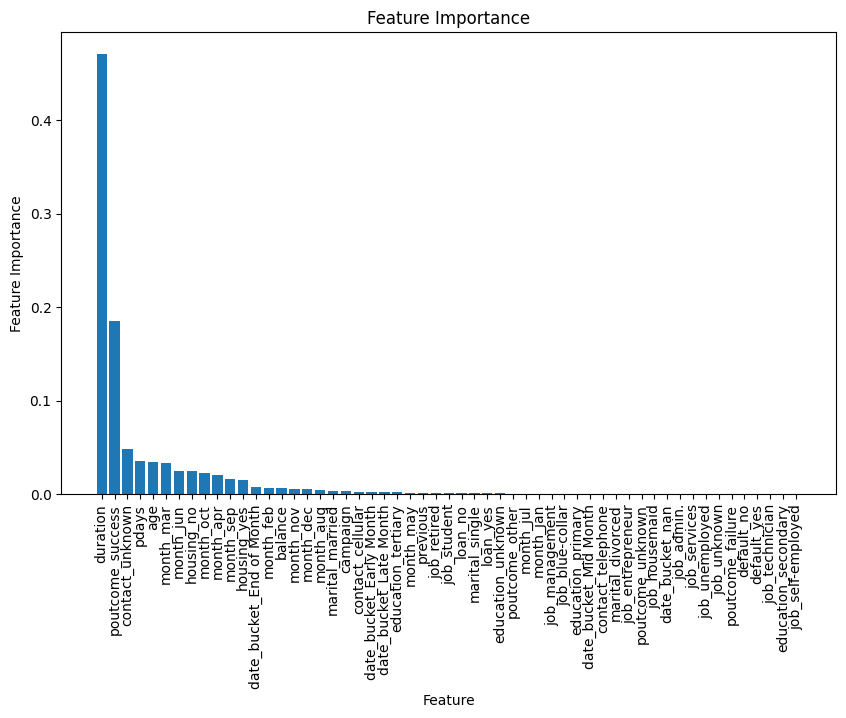

In [24]:
# Plotting bar graph for feature importance through gradient boosting
if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    feature_importance = best_model.feature_importances_

    # Get the names of the features (assuming X_train is a DataFrame or contains feature names)
    feature_names = X_train.columns

    # Sort the features by importance in descending order
    sorted_idx = np.argsort(feature_importance)[::-1]

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], align="center")
    plt.xticks(range(len(feature_importance)), feature_names[sorted_idx], rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importance")
    plt.show()
else:
    print("Feature importances are not available for this model.")

[[7424  528]
 [ 441  650]]


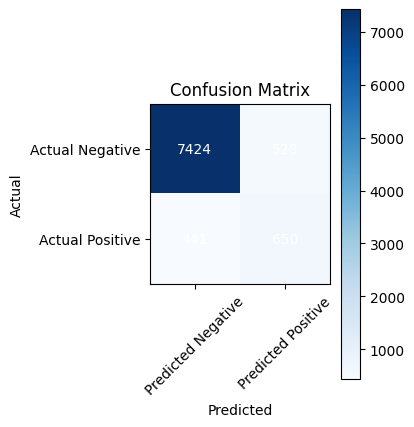

In [25]:
# Building confusion matrix for test data
build_confusion_matrix(y_test, y_pred)

In [26]:
# Building classification report for test data
build_report(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      7952
           1       0.55      0.60      0.57      1091

    accuracy                           0.89      9043
   macro avg       0.75      0.76      0.76      9043
weighted avg       0.90      0.89      0.89      9043



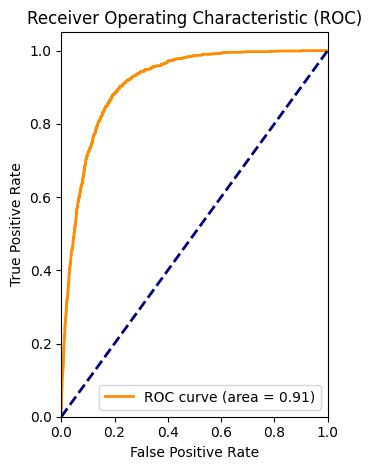

In [27]:
# Building Receiver Operating Characteristic curve for test data
build_ROC(X_test,y_test)

The model seems to perfrom well as it outperfroms the random classifier (dotted-diagonal). The area under curve coems to be 0.91 which is tending to a perfect classifier. Hence, we can say the model perfroms great.